In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
# evaluate knn on the sonar dataset with k-means ordinal discretization transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import warnings
import time
warnings.filterwarnings("ignore")


In [47]:
heart = pd.read_csv('dataset/healthcare-dataset-stroke-data.csv')
#heart = pd.read_csv('dataset/heart_failure_clinical_records_dataset.csv')

In [51]:
dataset = heart

In [52]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [53]:
dataset = dataset.drop('id', axis=1)
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column .
dataset['ever_married']= label_encoder.fit_transform(dataset['ever_married'])
dataset['work_type']= label_encoder.fit_transform(dataset['work_type'])
dataset['Residence_type']= label_encoder.fit_transform(dataset['Residence_type'])
dataset['smoking_status']= label_encoder.fit_transform(dataset['smoking_status'])
dataset['gender']= label_encoder.fit_transform(dataset['gender'])
dataset

gender   age  hypertension  heart_disease  ever_married  work_type  \
0          1  67.0             0              1             1          2   
1          0  61.0             0              0             1          3   
2          1  80.0             0              1             1          2   
3          0  49.0             0              0             1          2   
4          0  79.0             1              0             1          3   
...      ...   ...           ...            ...           ...        ...   
5105       0  80.0             1              0             1          2   
5106       0  81.0             0              0             1          3   
5107       0  35.0             0              0             1          3   
5108       1  51.0             0              0             1          2   
5109       0  44.0             0              0             1          0   

      Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0                  1             228.69  36.6               1       1  
1                  0             202.21   NaN               2       1  
2                  0             105.92  32.5               2       1  
3                  1             171.23  34.4               3       1  
4                  0             174.12  24.0               2       1  
...              ...                ...   ...             ...     ...  
5105               1              83.75   NaN               2       0  
5106               1             125.20  40.0               2       0  
5107               0              82.99  30.6               2       0  
5108               0             166.29  25.6               1       0  
5109               1              85.28  26.2               0       0  

[5110 rows x 11 columns]

In [55]:
dataset.bmi.replace(to_replace=np.nan, value=dataset.bmi.mean(), inplace=True)

In [13]:
#pip install imblearn
#!pip3 install imblearn --user

In [56]:
#from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [57]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [58]:
#Standerdize
def standardise(X):
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X) # centering and scaling
    return(scaled_features)

In [59]:

sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_resample(X, y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (9722, 10)
After OverSampling, the shape of train_y: (9722,) 

After OverSampling, counts of label '1': 4861
After OverSampling, counts of label '0': 4861


## Train the Support Vector Classifier

In [60]:
def calculate_model(param,X,y):
    
    recall_list_10 = []
    precision_list_10 = []
    specificity_10 = []
    f1_list_10 = []
    accuracy_10 = []
    roc_10 = []
    cpu_10 = []
    

    kfold = KFold(n_splits=10, shuffle=True)
    for i in range(30):
        recall_list = []
        precision_list = []
        specificity = []
        f1_list = []
        accuracy = []
        roc_list = []
        cpu = []
        
        for train_ix, test_ix in kfold.split(X, y):

            X_train , X_test = X[train_ix],X[test_ix]
            y_train , y_test = y[train_ix] , y[test_ix]
            t0= time.time()
            if (param == 0):
                model = SVC(probability=True)
                
            else:
                model = SVC(C=param['C'], gamma = param['gamma'], kernel= param['kernel'],probability=True )

          

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            #print(predictions)
            probs = model.predict_proba(X_test)
            #print(probs)
            probs = probs[:, 1]
            t1 = time.time() - t0
                        
            cm = confusion_matrix(y_test,predictions)
            f1_list.append(f1_score(y_test, predictions, average="weighted")*100)

            recall_list.append(recall_score(y_test, predictions, average="weighted")*100)
            precision_list.append(precision_score(y_test, predictions, average="weighted")*100)
            specificity1 = cm[1,1]/(cm[0,1]+cm[1,1])
            if not np.isnan(specificity1):
                specificity.append( (cm[1,1]/(cm[0,1]+cm[1,1]))*100)
            accuracy.append(accuracy_score(y_test, predictions)*100)
            roc_list.append(roc_auc_score(y_test, probs)*100)
            cpu.append(t1)

        precision_list_10.append(sum(precision_list)/10)
        specificity_10.append(sum(specificity)/len(specificity))
        f1_list_10.append(sum(f1_list)/10)
        accuracy_10.append(sum(accuracy)/10)
        recall_list_10.append(sum(recall_list)/10)
        roc_10.append(sum(roc_list)/10)
        cpu_10.append(sum(cpu)/10)
        
    plt.figure(figsize=(10,6))
    plt.plot(range(0,30),accuracy_10,color='blue', linestyle='dashed', 
             marker='o',markerfacecolor='red', markersize=10)
    plt.title('checking the variance in 30 iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()
   
    accu = sum(accuracy_10)/30
    pre = sum(precision_list_10)/30
    spec = sum(specificity_10)/30
    rec =  sum(recall_list_10)/30
    f1 =  sum(f1_list_10)/30
    roc = sum(roc_10)/30
    cpu = sum(cpu_10)/30
    
    return([accu,pre,spec,rec,f1,roc,cpu])



from sklearn.model_selection import cross_validate
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
model = SVC()
list_pre = []
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'roc_auc': 'roc_auc'}
score = cross_validate(model,scaled_features,y,cv=10, scoring =scoring)
print(score['test_accuracy'].mean())


In [21]:
dict_SV = {}

## First Model without preprocessing 

In [ ]:
X = x_train_res
y = y_train_res

#from collections import defaultdict
scaled_features = standardise(X)

param = 0
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['SVM'] = result
dict_SV



In [22]:
dict_SV['SVM'] = [82.45125448028675,
  83.60377740685885,
  81.4061822324969,
  82.45125448028675,
  82.348459139646,
  89.73988134790835,
  0.01444612503051758]

## Hypertune model using grid search

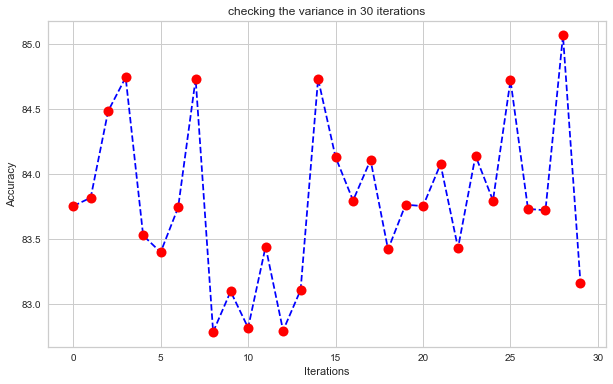

{'SVM': [82.45125448028675,
  83.60377740685885,
  81.4061822324969,
  82.45125448028675,
  82.348459139646,
  89.73988134790835,
  0.01444612503051758],
 'Hypertuned': [83.79247311827956,
  85.14911952369741,
  81.01027111955165,
  83.79247311827956,
  83.57565541570321,
  90.33552719810558,
  0.012071444193522136]}

In [123]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['Hypertuned'] = result
dict_SV


## K-means

In [61]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


X = x_train_res
y_old =  y_train_res

scaled_features = standardise(X)


model = KMeans()
#visualizer = KElbowVisualizer(model, k=(1,12)).fit(scaled_features)
#visualizer.show()

In [62]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2,init='k-means++', random_state=0).fit(scaled_features)

In [63]:
y= kmeans.predict(scaled_features)

In [64]:
df = pd.DataFrame(scaled_features , columns= ['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status'])
#df['Cluster'] = y
#df['actual'] = y_old
df.head()

gender       age  hypertension  heart_disease  ever_married  work_type  \
0  1.246341  0.539165     -0.516899       3.068462      0.576421  -0.091028   
1 -0.939105  0.268147     -0.516899      -0.421251      0.576421   0.970888   
2  1.246341  1.126372     -0.516899       3.068462      0.576421  -0.091028   
3 -0.939105 -0.273890     -0.516899      -0.421251      0.576421  -0.091028   
4 -0.939105  1.081203      2.429132      -0.421251      0.576421   0.970888   

   Residence_type  avg_glucose_level       bmi  smoking_status  
0        1.026140           2.008011  1.094654       -0.452125  
1       -1.150287           1.526809 -0.075510        0.592880  
2       -1.150287          -0.222998  0.472126        0.592880  
3        1.026140           0.963832  0.760615        1.637885  
4       -1.150287           1.016350 -0.818479        0.592880

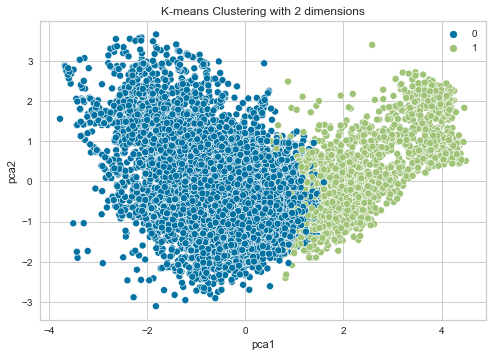

In [27]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(scaled_features)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=y, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

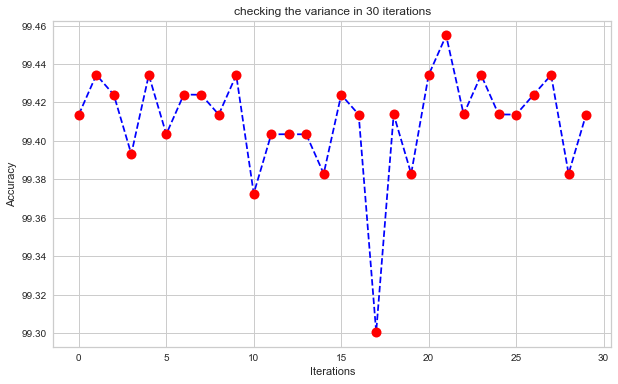

In [28]:

X=scaled_features
                                                   
param = 0
#print(param)

result = calculate_model(param,X,y)
result
dict_SV['kmeans_2_clusters'] = result

In [29]:
dict_SV

{'SVM': [82.45125448028675,
  83.60377740685885,
  81.4061822324969,
  82.45125448028675,
  82.348459139646,
  89.73988134790835,
  0.01444612503051758],
 'kmeans_2_clusters': [99.4106094313262,
  99.41240628872698,
  99.45341187410568,
  99.4106094313262,
  99.4073270663118,
  99.9852593823429,
  0.8261025706926982]}

## shap visualization  on 2 clusters 

In [65]:
import shap
shap.initjs()

In [66]:
import xgboost
model = xgboost.XGBClassifier().fit(df, y)

# compute SHAP values
explainer = shap.Explainer(model, df)
shap_values = explainer(df)

[14:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 95%|=================== | 9254/9722 [00:15<00:00]       

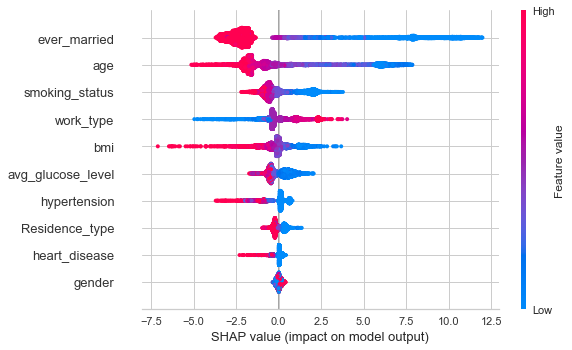

In [67]:
shap.plots.beeswarm(shap_values)

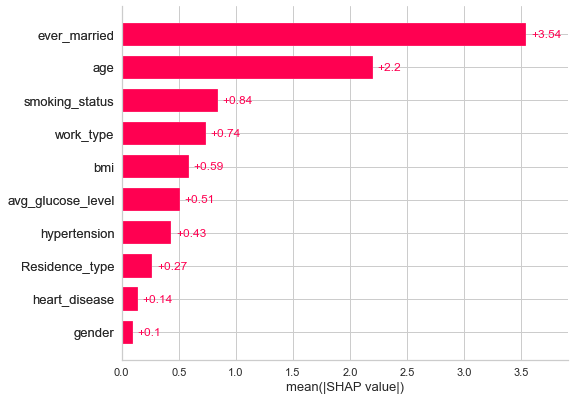

In [68]:
shap.plots.bar(shap_values)

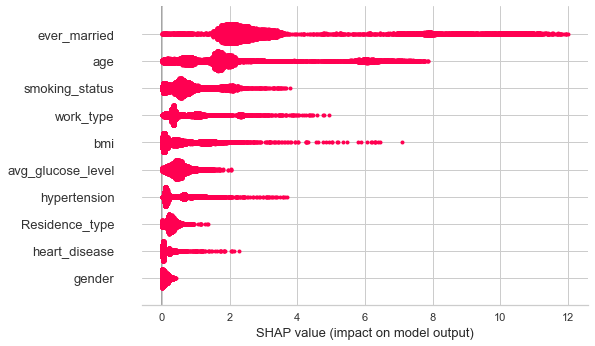

In [148]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")


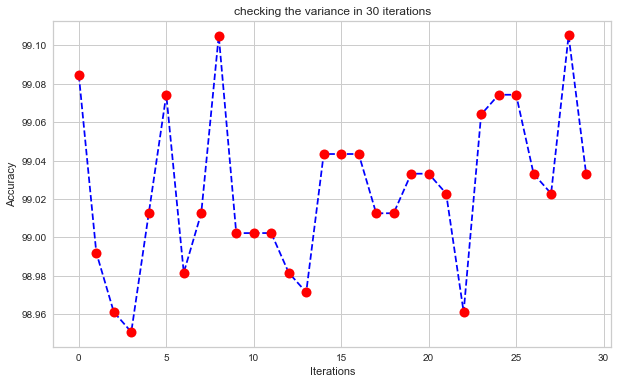

In [156]:
X=scaled_features                                                   
param = 0
#print(param)

result = calculate_model(param,X,y)
result
dict_SV['kmeans_ideal_Clusters'] = result

In [157]:
dict_SV

{'SVM': [82.45125448028675,
  83.60377740685885,
  81.4061822324969,
  82.45125448028675,
  82.348459139646,
  0.01444612503051758],
 'kmeans_2_clusters': [99.02934971246988,
  99.0343387253002,
  99.68445468979024,
  99.02934971246988,
  99.02898987442613,
  1.6766349705060324],
 'kmeans_ideal_Clusters': [99.02487921479397,
  99.03084019762105,
  99.67546265170958,
  99.02487921479397,
  99.02445911025283,
  1.702072241306305],
 'kmeans+Shap': [99.30260764933027,
  99.30744706780379,
  99.93501190159287,
  99.30260764933027,
  99.30299138839456,
  0.8387956960995991]}

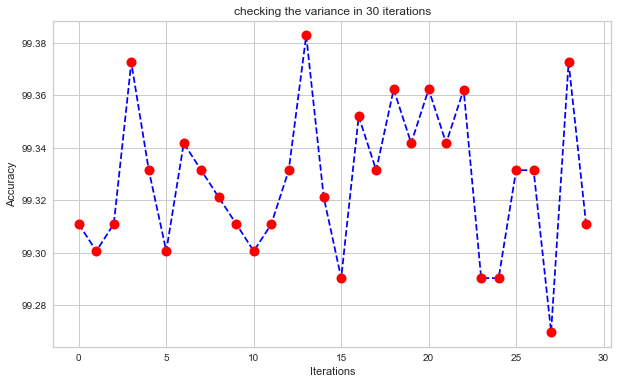

In [37]:
X=scaled_features
feat_cols = [1,2,4,5,7,8,9]
#feat_cols = [2,4,3,1,7,5,8,9]
X = X[:,feat_cols]

param =0
#print(param)

#X=scaled_features
result = calculate_model(param,X,y)
result
dict_SV['kmeans+Shap'] = result

In [45]:
#dict_SV['kmeans+Shap'] = result
dict_SV

{'SVM': [82.45125448028675,
  83.60377740685885,
  81.4061822324969,
  82.45125448028675,
  82.348459139646,
  89.73988134790835,
  0.01444612503051758],
 'kmeans_2_clusters': [99.4106094313262,
  99.41240628872698,
  99.45341187410568,
  99.4106094313262,
  99.4073270663118,
  99.9852593823429,
  0.8261025706926982],
 'kmeans+Shap': [99.32730605638945,
  99.32908380201367,
  99.35848424840887,
  99.32730605638945,
  99.32313259465113,
  99.97934517096154,
  0.7346561209360758]}

In [119]:
#df_dict.to_excel('xl_result/SVM_stroke_30.xlsx')

In [39]:
df_dict = pd.DataFrame.from_dict(dict_SV,orient='index', columns= ['Accuracy','Precision','Specificity','Recall','F1_score','Roc','CPU_time'])
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
SVM                82.451254  83.603777    81.406182  82.451254  82.348459   
kmeans_2_clusters  99.410609  99.412406    99.453412  99.410609  99.407327   
kmeans+Shap        99.327306  99.329084    99.358484  99.327306  99.323133   

                         Roc  CPU_time  
SVM                89.739881  0.014446  
kmeans_2_clusters  99.985259  0.826103  
kmeans+Shap        99.979345  0.734656

In [42]:
# Adding Number of features
df_dict['no_of_features'] = [10,10,7]

In [43]:
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
SVM                82.451254  83.603777    81.406182  82.451254  82.348459   
kmeans_2_clusters  99.410609  99.412406    99.453412  99.410609  99.407327   
kmeans+Shap        99.327306  99.329084    99.358484  99.327306  99.323133   

                         Roc  CPU_time  no_of_features  
SVM                89.739881  0.014446              10  
kmeans_2_clusters  99.985259  0.826103              10  
kmeans+Shap        99.979345  0.734656               7